In [1]:
import numpy as np
from scipy import signal
import adi

In [2]:
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1e6):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

In [9]:
sample_rate = 20e6 # Hz
center_freq = 2449.5e6 # Hz

sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_buffer_size = 1024
sdr.tx_hardwaregain_chan0 = 0 # Increase to increase tx power, valid range is -90 to 0 dB

In [11]:
# N = 10000 # number of samples to transmit at once
# t = np.arange(N)/sample_rate
# samples = 0.5*np.exp(2.0j*np.pi*100e3*t) # Simulate a sinusoid of 100 kHz, so it should show up at 915.1 MHz at the receiver
# win = signal.firwin(3, [0.1,0.2], pass_zero=False)
# x = np.linspace(-10,10,N)
# samples = np.sinc(x)
# samples = np.convolve(np.random.normal(0,1,10000),win)
samples = np.random.normal(0,1,1024) + 1j*np.random.normal(0,1,1024)
samples = np.convolve(samples,np.hamming(len(samples)))
samples *= 2**14 # The

# Transmit our batch of samples 100 times, so it should be 1 second worth of samples total, if USB can keep up
sdr.tx_cyclic_buffer = True  
sdr.tx(samples) # transmit the batch of samples once

In [12]:
sdr.tx_destroy_buffer()

In [62]:
sdr

Pluto(uri="ip:192.168.2.1") object "PlutoSDR" with following key properties:

rx_lo:                   899.999998   MHz, Carrier frequency of RX path
rx_hardwaregain_chan0    0            dB, Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'
rx_rf_bandwidth:         1.0          MHz, Bandwidth of front-end analog filter of RX path
gain_control_mode_chan0: manual       Receive path AGC Options: slow_attack, fast_attack, manual

tx_lo:                   100.299998   MHz, Carrier frequency of TX path
tx_hardwaregain_chan0:   0            dB, Attenuation applied to TX path
tx_rf_bandwidth:         0.525        MHz, Bandwidth of front-end analog filter of TX path
tx_cyclic_buffer:        0            Toggles cyclic buffer

filter:                  [128.0, 4.0, 128.0, 4.0] FIR filter file
sample_rate:             0.524999     MSPS, Sample rate RX and TX paths
loopback:                0            0=Disabled, 1=Digital, 2=RF


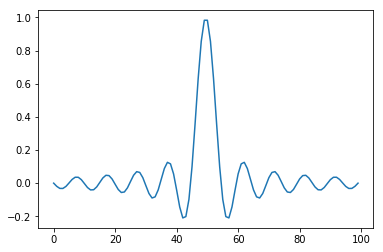

In [30]:
import matplotlib.pyplot as plt

x  = np.linspace(-10,10,100)
y1 = np.sinc(x)
y = np.convolve(np.sinc(x), np.hamming(10))
plt.plot(y1)

<function matplotlib.pyplot.show(*args, **kw)>

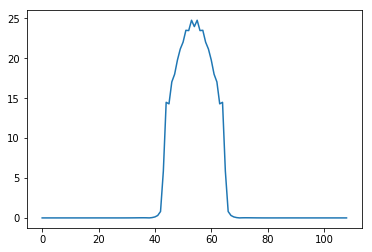

In [29]:
plt.plot(np.fft.fftshift(np.abs(np.fft.fft(y))))
plt.show